In [5]:
import copernicusmarine
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as signal
import xarray as xr

from scipy.interpolate import interp1d
from scipy.signal import medfilt
from utils.data_reading.sound_data.station import StationsCatalog

In [58]:
#Import data from Copernicus -> import the data from one station and for the whole duration of a campaign

lon_min, lon_max, lat_min, lat_max = 45.54, 45.56, -12.51, -12.49 # Select the latitude and longitude from one station
dataset = "cmems_mod_glo_phy_myint_0.083deg_P1D-m"

date_start_str = "2021-07-01T00:00:00" # Start of campaign
date_end_str = "2024-09-28T00:00:00" # End of campaign
date_start = datetime.strptime(date_start_str, '%Y-%m-%dT%H:%M:%S')
date_end = datetime.strptime(date_end_str, '%Y-%m-%dT%H:%M:%S')

# This process must be done for the definitive data and the interim data (change date_start_str and date_end_str)

variables = ['uo','vo'] # Variables extracted from the dataset
output = '.'
depth_min, depth_max = 0, 6000
copernicusmarine.subset(
        dataset_id=dataset,
        variables=variables,
        minimum_longitude=lon_min,
        maximum_longitude=lon_max,
        minimum_latitude=lat_min,
        maximum_latitude=lat_max,
        start_datetime=date_start,
        end_datetime=date_end,
        minimum_depth=0,
        maximum_depth=depth_max,
        output_directory = output)

# Concatenate the definitive and interime datasets

ds1 = xr.open_dataset("/data_copernicus/temporally_disconnected/h4/h4_2020-10-13_to_2021-06-30.nc") # Path to the first file
ds2 = xr.open_dataset("/data_copernicus/temporally_disconnected/h4/h4_2021-07-01_to_2024-09-27.nc") # Path to the second file
ds_concat = xr.concat([ds1, ds2], dim='time')
ds_concat.to_netcdf("h4_total_time.nc") # Name the concatenated new file

INFO - 2025-03-27T10:42:00Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username:Copernicus Marine password:

INFO - 2025-03-27T10:42:11Z - Selected dataset version: "202311"
INFO - 2025-03-27T10:42:11Z - Selected dataset part: "default"
WARNING - 2025-03-27T10:42:13Z - Some of your subset selection [2021-06-30 22:00:00+00:00, 2024-09-27 22:00:00+00:00] for the time dimension exceed the dataset coordinates [2021-07-01 00:00:00+00:00, 2025-02-25 00:00:00+00:00]
WARNING - 2025-03-27T10:42:13Z - Some of your subset selection [0, 6000] for the depth dimension exceed the dataset coordinates [0.49402499198913574, 5727.9169921875]
INFO - 2025-03-27T10:42:14Z - Starting download. Please wait...


  0%|          | 0/1300 [00:00<?, ?it/s]

INFO - 2025-03-27T10:42:19Z - Successfully downloaded to cmems_mod_glo_phy_myint_0.083deg_P1D-m_uo-vo_45.50E_12.50S_0.49-5727.92m_2021-07-01-2024-09-27.nc


cmems_mod_glo_phy_myint_0.083deg_P1D-m


In [56]:
#Choix des variables
station_name = "MAHY13" # Select the station
duration = 1 # Select the number of weeks from the start of the campaign
depth_choice = 1300 # Select a depth (m) for the hydrology data (e.g. the SOFAR canal)
#frequnency -> il faudrait réussir à faire pareille que pour depth


/tmp/ipykernel_4428/4119957027.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_4428/4119957027.py:56: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


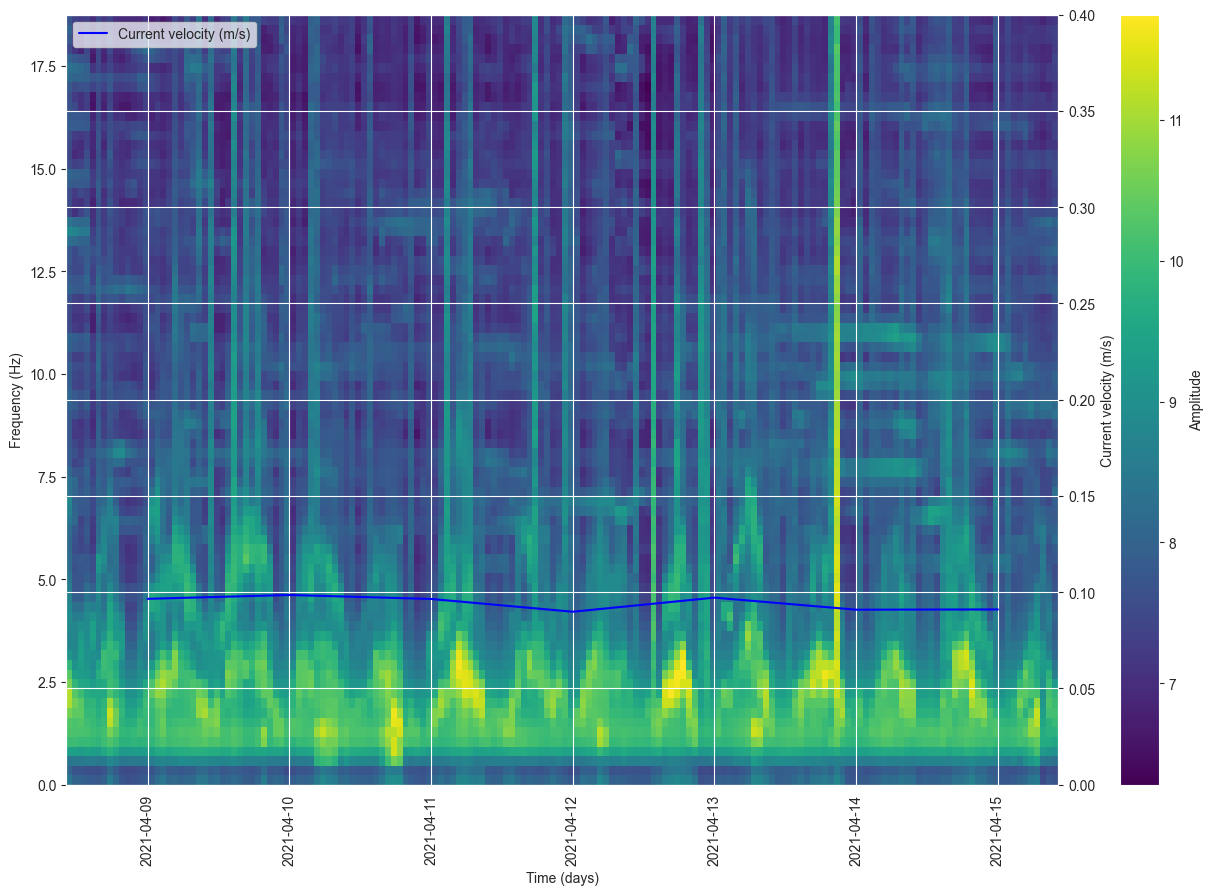

In [57]:
# Chargement des données
sys.path.append("/home/imonge/PycharmProjects/PythonProject/toolbox/src")
mahy_data = pd.read_csv("/media/imonge/CORSAIR/MAHY/MAHY.csv") # Path of a directory containing one MAHY station
mahy_data["date_start"] = pd.to_datetime(mahy_data["date_start"])
mahy_data["date_end"] = pd.to_datetime(mahy_data["date_end"])

catalog_path = "/media/imonge/CORSAIR"  # path of a directory containing (with up to 3 levels) a dataset descriptor (.csv, .yaml)
station_metadata = mahy_data[mahy_data.station_name == station_name]
stations = StationsCatalog(catalog_path)
manager = stations.by_name(station_name)[0].get_manager()

hydro_data = xr.open_dataset("/home/imonge/PycharmProjects/PythonProject/toolbox/src/data_copernicus/hydro_3/h3_total_time.nc") # Path of a directory containing the hydrology data (copernicus) for the station selected

# LTAS & vitesse du courant
date_start = station_metadata.date_start.item()
date_end = station_metadata.date_start.item() + datetime.timedelta(weeks=duration)
step = datetime.timedelta(seconds=3600)  # on lit les données par segments d'une heure
n_steps = (date_end-date_start)/step  # nombre de segments à calculer, attention c'est un nombre flottant
n_steps = int(n_steps)  # on transforme le nombre flottant en nombre entier
psds = []  # liste des psd de chaque segment, on va la remplir segment par segment

for i in range(n_steps):
    segment_start = date_start + i * step  # début du ième segment
    segment_end = date_start + (i+1) * step   # fin du ième segment
    data = manager.get_segment(segment_start, segment_end)
    psd_frequencies, psd = signal.welch(data, fs=240, nperseg=1024)  # fs est la fréquence d’échantillonnage, nperseg le nombre de points utilisés par transformée de Fourier. La résolution fréquentielle du résultats est 240/256 Hz
    psds.append(psd)

fig, ax = plt.subplots(figsize = (16,10))
ax1 = ax.twinx() # Second axis for current speed
f_max = 80 # Maximum frequency on the spectrogram
sp = ax.imshow(np.log10(psds)[:,:f_max].T, aspect="auto", cmap="viridis", origin="lower", extent=(date_start, date_end, psd_frequencies[0], psd_frequencies[f_max]))

t = pd.to_datetime(hydro_data["time"])
mask = (t>date_start) & (t<date_end) # Filter to only select the campaign dates

# Color bar amplitudes
cbar = plt.colorbar(sp, ax=ax)
cbar.set_label("Amplitude")

depth_index = np.argmin(abs(hydro_data["depth"].data-depth_choice)) # Finds the index in the dataset corresponding to the depth chosen
uo = np.array(hydro_data["uo"][:,depth_index]).flatten()
vo = np.array(hydro_data["vo"][:,depth_index]).flatten()

velocity_magnitude = np.sqrt(uo**2+vo**2)[mask] # Current velocity
ax1.plot(t[mask], velocity_magnitude,label="Current velocity (m/s)", color="blue")
ax1.set_ylim(0,0.4) #limites ax1
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.grid(False, axis='y') # No grid for the frequency

ax.set_xlabel("Time (days)")
ax.set_ylabel("Frequency (Hz)")
ax1.set_ylabel("Current velocity (m/s)")
ax1.legend(loc="upper left")

fig.show()

/tmp/ipykernel_4428/2123585153.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_4428/2123585153.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


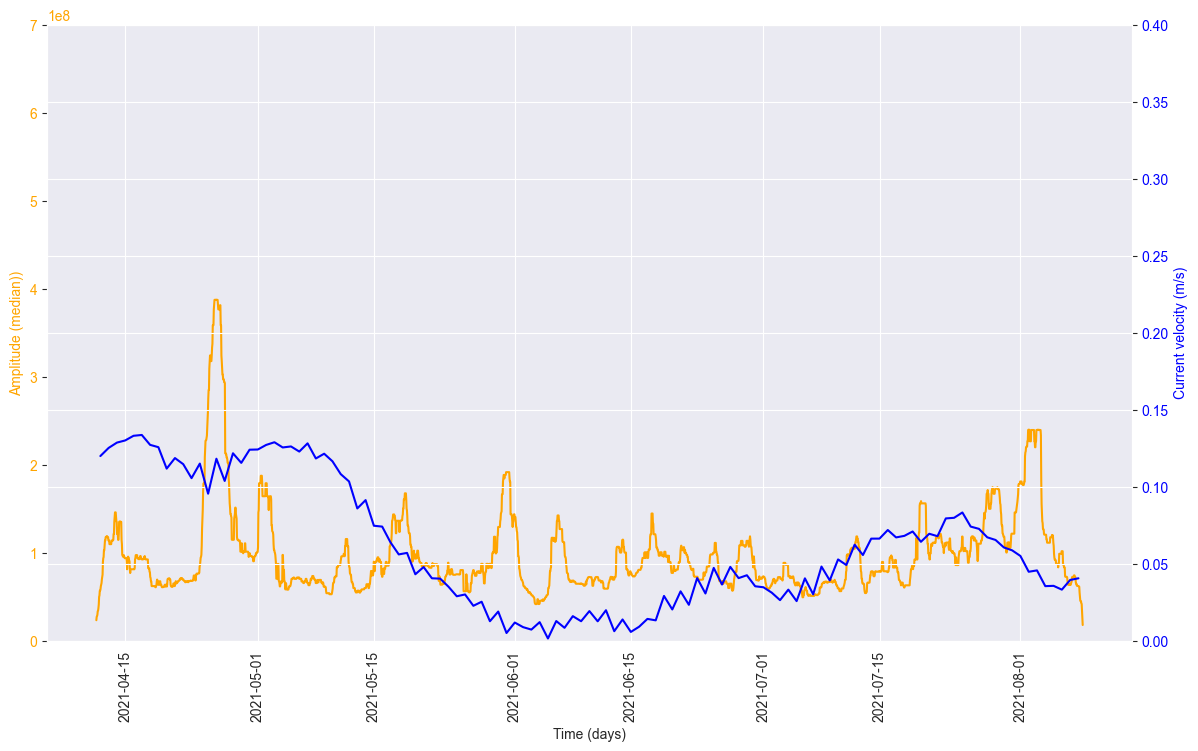

In [38]:
# Amplitude for a given freqeuncy & current velocity

frequency_index = 20 #choix d'une fréquence -> Pour l'instant ça ne correspond pas à une fréquence en Hz, mais à la position dans le tableau psd_frequencies
psds = np.array(psds)
amplitude = psds[:,frequency_index]
t = pd.to_datetime(hydro_data["time"])
mask = (t>date_start) & (t<date_end) # Only takes dates from the campaign

t_amplitude = pd.date_range(
    start=date_start,
    end=date_end,
    periods=n_steps)

amplitude_filt = medfilt(amplitude, kernel_size=51)

uo = np.array(hydro_data["uo"][:,depth_index]).flatten()
vo = np.array(hydro_data["vo"][:,depth_index]).flatten()

fig, ax = plt.subplots(figsize = (14,8))

ax.plot(t_amplitude, amplitude_filt, color="orange", label="Amplitude (median)")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Amplitude (median)", color="orange")
ax.tick_params(axis='y', labelcolor='orange')
#ax.plot(t_amplitude, amplitude, color="red", label="Amplitude")
ax.set_ylim(0,0.07e10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.grid(False, axis='y') # No grid for the amplitude

ax1 = ax.twinx()
ax1.plot(t[mask], velocity_magnitude, color="blue", label="Current velocity (m/s)")
ax1.set_ylim(0,0.4) #limites ax1
ax1.set_ylabel("Current velocity (m/s)", color="blue")
ax1.tick_params(axis='y', labelcolor='blue')

fig.show()

# A faire : automatiser frequency et profondeur
#### mettre toutes les entrées de données en début de script

In [39]:
# Test the correlation between the amplitude and the current velocity

amplitude_filt = medfilt(amplitude, kernel_size=51)
f = interp1d(pd.to_numeric(t[mask]), velocity_magnitude, bounds_error=False)(pd.to_numeric(t_amplitude))
nanmask = ~np.isnan(f) # remove nan values
np.corrcoef(f[nanmask], amplitude_filt[nanmask])

array([[1.        , 0.15264685],
       [0.15264685, 1.        ]])